Goal: explore how ground truth derives (->) best threshold and derives (->) predicted annotations  

Ground truth: the true labels used to train txt2onto models.  
Best threshold: fbeta-score cut off value on the predictions (probabilities) from txt2onto models.  
predicted annotation: the classified binary annotation by applying the best threshold.  
1. ground truth (x) -> best threshold (y): explore how the best threshild is compared to the ground truth from which the best threshold is generated.  
2. best threshold (x) -> predicted annotation (y): explore how the predicted annotation is compared to the best threshild from which the predicted annotion is generated.  

Date: 2025-10-27  
Author: Junxia Lin  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

In [ ]:
# import the data
prior_df = pd.read_csv("../data/true_label__inst_type=study__task=disease.csv.gz", compression="gzip", sep=",")
ic_df = pd.read_csv("../data/MONDO_IC.csv", sep=",")
log2auprc_df = pd.read_csv("../data/disease_model_stats.csv", sep=",")
best_th_df_f05 = pd.read_csv("../results/study/f0.5_best_threshold.csv", sep = "\t")
label_f05 = pd.read_csv("../results/study/threshold_annotation_analysis_f05.csv", sep=",")
id_map = pl.read_parquet("../data/id_map.parquet")

In [32]:
id_map = id_map.to_pandas()
id_map.head()

,id,name
0,MONDO:0000001,disease
1,MONDO:0000004,adrenocortical insufficiency
2,MONDO:0000005,"alopecia, isolated"
3,MONDO:0000009,"inherited bleeding disorder, platelet-type"
4,MONDO:0000014,"colorblindness, partial"


In [6]:
# f0.5: best threshold
best_th_df_f05["log2(best_th/prior)"] = np.log2(best_th_df_f05["best_threshold"]/best_th_df_f05["prior"])
best_th_df_f05 = best_th_df_f05.merge(id_map, left_on="task", right_on="id", how="left")
best_th_df_f05 = best_th_df_f05.drop(columns=["id"])
best_th_df_f05.head()

,task,best_threshold,prior,log2(auprc/prior),log2(best_th/prior),name
0,MONDO:0020120,0.134234,0.012228,5.825001,3.456460,skeletal muscle disorder
1,MONDO:0700092,0.194167,0.023098,5.259027,3.071466,neurodevelopmental disorder
2,MONDO:0005101,0.053404,0.006803,7.065371,2.972771,ulcerative colitis
3,MONDO:0021143,0.082648,0.038043,4.553959,1.119331,melanocytic neoplasm
4,MONDO:0005072,0.079651,0.034014,4.845951,1.227588,neuroblastoma


In [17]:
best_th_df_f1.shape, best_th_df_f05.shape, best_th_df_f_merge.shape

((222, 6), (222, 6), (222, 10))

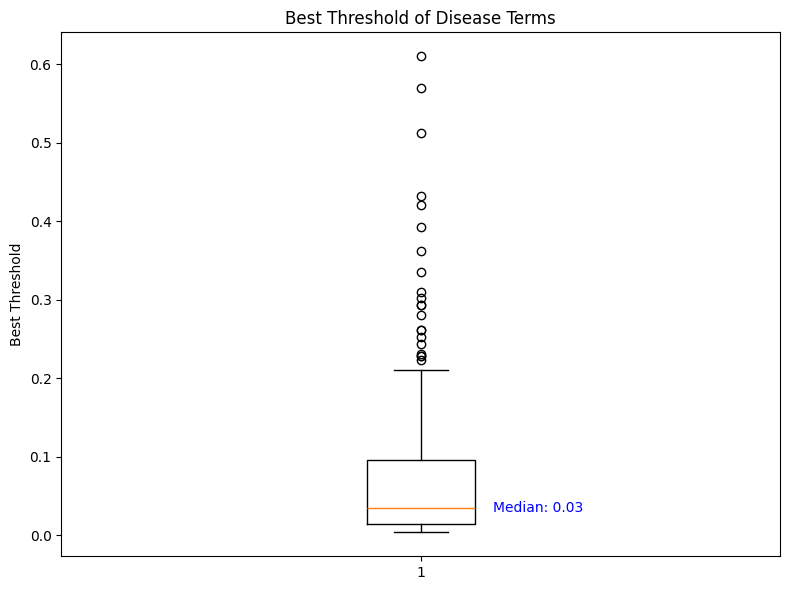

In [15]:
# boxplot for the best threshold
plt.figure(figsize=(8, 6))
plt.boxplot(best_th_df_f05["best_threshold"])
median_value_f05 = best_th_df_f05["best_threshold"].median()
plt.text(1.1, median_value_f05, f"Median: {median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.ylabel("Best Threshold")
plt.title("Best Threshold of Disease Terms")
plt.tight_layout()
# Show the plot
plt.show()


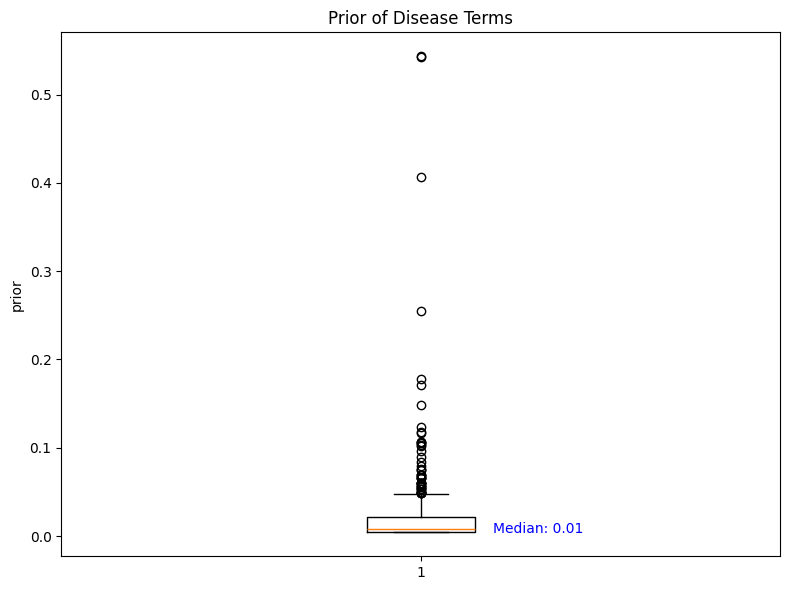

In [16]:
# boxplot for the best threshold
plt.figure(figsize=(8, 6))
plt.boxplot(best_th_df_f05["prior"])
median_value_f05 = best_th_df_f05["prior"].median()
plt.text(1.1, median_value_f05, f"Median: {median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.ylabel("prior")
plt.title("Prior of Disease Terms")
plt.tight_layout()
# Show the plot
plt.show()

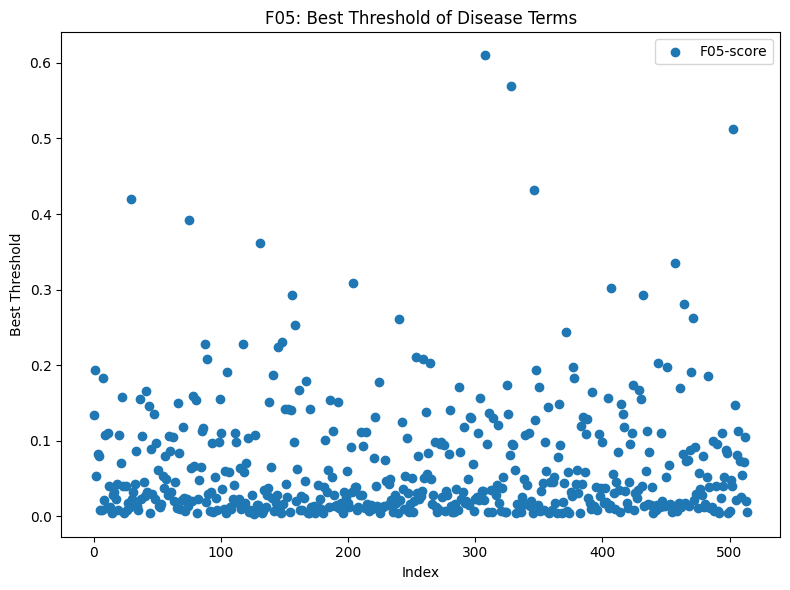

In [17]:
# scatter plot
plt.figure(figsize=(8,6))
plt.scatter(best_th_df_f05.index, best_th_df_f05["best_threshold"], label='F05-score',)
plt.xlabel("Index")
plt.ylabel("Best Threshold")
plt.title("F05: Best Threshold of Disease Terms")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

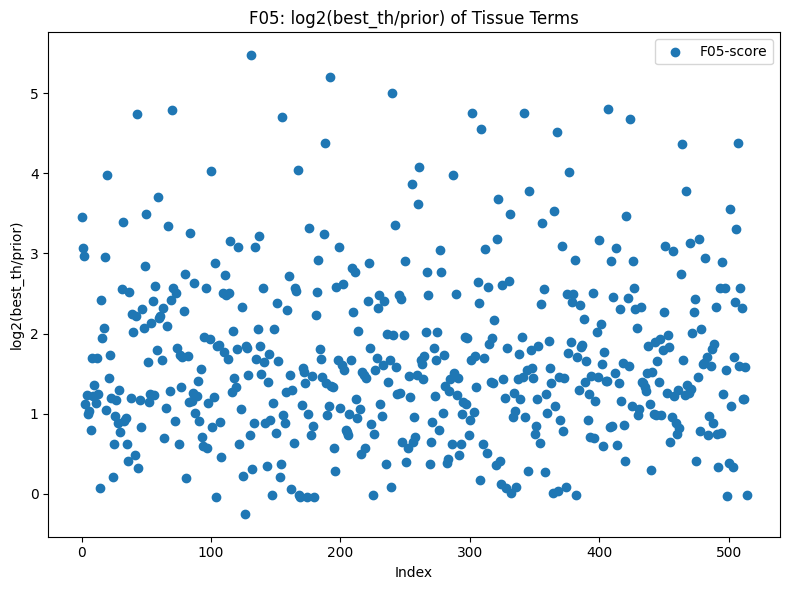

In [18]:
# scatter plot
plt.figure(figsize=(8,6))
plt.scatter(best_th_df_f05.index, best_th_df_f05["log2(best_th/prior)"], label='F05-score',)
plt.xlabel("Index")
plt.ylabel("log2(best_th/prior)")
plt.title("F05: log2(best_th/prior) of Tissue Terms")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

In [19]:
# the top terms having the highest threshold
th_top_10_f05 = best_th_df_f05.sort_values(by="best_threshold", ascending = False).head(10)
th_top_10_f05

,task,best_threshold,prior,log2(auprc/prior),log2(best_th/prior),name
308,MONDO:0023370,0.610012,0.543478,0.867999,0.166615,neoplastic disease or syndrome
328,MONDO:0005070,0.569765,0.542120,0.869651,0.071755,neoplasm
503,MONDO:0004992,0.512290,0.406250,1.250621,0.334592,cancer
346,MONDO:0005138,0.432314,0.031507,4.748298,3.778343,lung carcinoma
29,MONDO:0004993,0.420037,0.170532,2.273984,1.300474,carcinoma
75,MONDO:0002602,0.392526,0.255435,1.849329,0.619832,central nervous system disorder
131,MONDO:0004298,0.361918,0.008152,6.585637,5.472333,stomach disorder
457,MONDO:0005814,0.335453,0.040928,4.248823,3.034961,intestinal cancer
204,MONDO:0005626,0.309243,0.177989,2.211357,0.796950,epithelial neoplasm
407,MONDO:0002050,0.301999,0.010870,5.743754,4.796175,depressive disorder


Analysis:  
The distribution of the best thresholds across the disease terms are very similar with a median of 0.03 for F0.5.   

### txt2onto models label

In [20]:
# F0.5: combine the best threshold, prior, ic, pos, logarprc
prior = []
ic = []
pos = []
auprcprior = []
for i in best_th_df_f05["task"]:
    prior_df_sub = prior_df[["Unnamed: 0", i]]
    prior_df_sub = prior_df_sub[(prior_df_sub != 0).all(axis=1)]
    prior_df_sub[i] = prior_df_sub[i].replace(-1, 0)
    prior.append(prior_df_sub[i].mean())
    ic_value = ic_df.loc[ic_df['node'] == i, 'IC'].values[0]
    ic.append(ic_value)
    pos_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'num_of_pos'].values[0]
    pos.append(pos_value)
    auprc_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'log2(auprc/prior)'].values[0]
    auprcprior.append(auprc_value)

# data used to train txt2onto
txt2onto_label_f05 = pd.DataFrame({"task": best_th_df_f05["task"], "best_threshold": best_th_df_f05["best_threshold"], "prior": prior, "ic": ic, "num_of_pos": pos, "log2(auprc/prior)": auprcprior})
txt2onto_label_f05 = txt2onto_label_f05.merge(id_map, left_on="task", right_on="id", how="left")
txt2onto_label_f05 = txt2onto_label_f05.drop(columns=["id"])
txt2onto_label_f05

,task,best_threshold,prior,ic,num_of_pos,log2(auprc/prior),name
0,MONDO:0020120,0.134234,0.011697,3.846209,34,5.836350,skeletal muscle disorder
1,MONDO:0700092,0.194167,0.022307,4.146013,66,5.140328,neurodevelopmental disorder
2,MONDO:0005101,0.053404,0.007619,8.958197,22,6.936638,ulcerative colitis
3,MONDO:0021143,0.082648,0.036997,5.286125,109,4.615338,melanocytic neoplasm
4,MONDO:0005072,0.079651,0.034286,7.284221,101,4.640827,neuroblastoma
...,...,...,...,...,...,...,...
510,MONDO:0004994,0.054290,0.011973,4.404320,35,5.340768,cardiomyopathy
511,MONDO:0002691,0.071590,0.031421,5.674783,92,4.628270,liver cancer
512,MONDO:0004095,0.104790,0.047152,5.303219,138,4.235846,b-cell neoplasm
513,MONDO:0003540,0.020512,0.006034,8.958197,18,7.437752,acute t cell leukemia


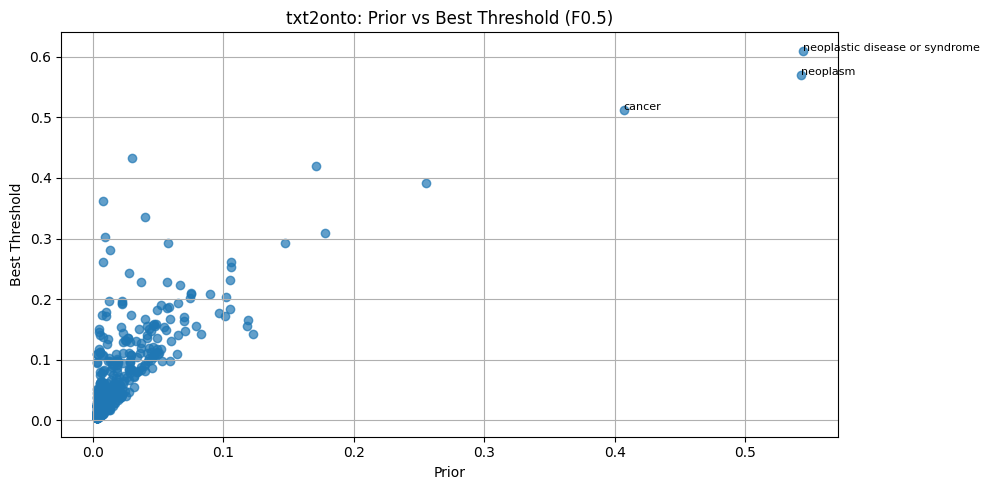

In [52]:
# prior
plt.figure(figsize=(10, 5))
plt.scatter(txt2onto_label_f05['prior'], txt2onto_label_f05['best_threshold'], alpha = 0.7)

# Fit a linear regression line
#m, b = np.polyfit(txt2onto_label_f05['prior'], txt2onto_label_f05['best_threshold'], 1)
#plt.plot(txt2onto_label_f05['prior'], m * txt2onto_label_f05['prior'] + b, color='blue', label='Regression line')

# Add labels
for i, row in txt2onto_label_f05.iterrows():
    if row['best_threshold'] > 0.5:
        plt.text(row['prior'], row['best_threshold'], row['name'], fontsize=8, ha='left')

plt.xlabel('Prior')
plt.ylabel('Best Threshold')
plt.title('txt2onto: Prior vs Best Threshold (F0.5)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# points on the very right of the plot
far_right_points_f05 = txt2onto_label_f05.sort_values(by = "prior", ascending = False).head()
far_right_points_f05

,task,best_threshold,prior,ic,num_of_pos,log2(auprc/prior),name
308,MONDO:0023370,0.610012,0.544070,1.645866,1600,0.860824,neoplastic disease or syndrome
328,MONDO:0005070,0.569765,0.542437,1.677959,1595,0.869749,neoplasm
503,MONDO:0004992,0.512290,0.406692,2.343025,1196,1.240034,cancer
75,MONDO:0002602,0.392526,0.255441,2.129124,751,1.858476,central nervous system disorder
204,MONDO:0005626,0.309243,0.177639,2.789982,522,2.082693,epithelial neoplasm


In [23]:
# points on the top left corner of the plot
top_left_points_f05 = txt2onto_label_f05.sort_values(by = "best_threshold", ascending = False).head()
top_left_points_f05

,task,best_threshold,prior,ic,num_of_pos,log2(auprc/prior),name
308,MONDO:0023370,0.610012,0.544070,1.645866,1600,0.860824,neoplastic disease or syndrome
328,MONDO:0005070,0.569765,0.542437,1.677959,1595,0.869749,neoplasm
503,MONDO:0004992,0.512290,0.406692,2.343025,1196,1.240034,cancer
346,MONDO:0005138,0.432314,0.030444,6.086517,89,4.755304,lung carcinoma
29,MONDO:0004993,0.420037,0.170945,3.162139,501,2.181929,carcinoma


Analysis:  
1. Relationship between prior and best threshold.  
    x: Prior - The proportion of positive studies.   
    y: Best threshold - the threshold that yields the best F0.5 socre.  

    a. Most terms have very low prior (<0.05).  
    b. The majority of the best thresholds fall between 0.0 and 0.2 with low prior.  
    c. As the prior increases, best thresholds also increases.  

    Takeaway: there seems a positive relationship between prior and the best threshold.  

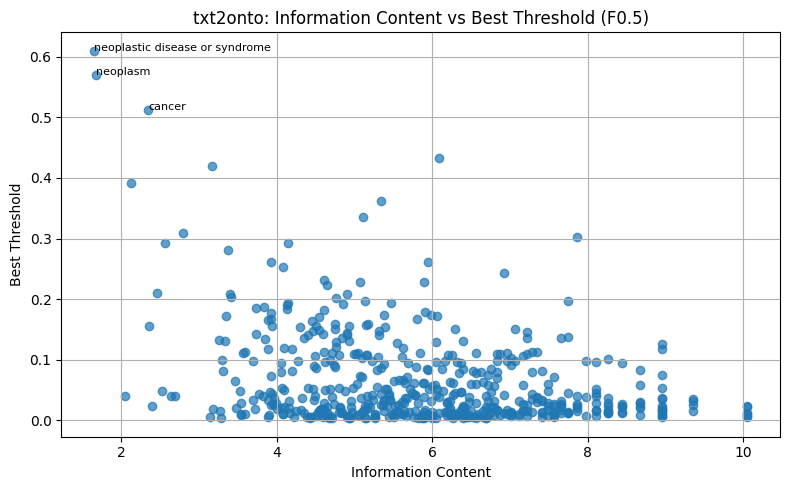

In [50]:
# Information Content
plt.figure(figsize=(8, 5))
plt.scatter(txt2onto_label_f05['ic'], txt2onto_label_f05['best_threshold'], alpha = 0.7)

# Fit a linear regression line
#m, b = np.polyfit(txt2onto_label_f05['ic'], txt2onto_label_f05['best_threshold'], 1)
#plt.plot(txt2onto_label_f05['ic'], m * txt2onto_label_f05['ic'] + b, color='blue', label='Regression line')

# Add labels
for i, row in txt2onto_label_f05.iterrows():
    if row['best_threshold'] > 0.5:
        plt.text(row['ic'], row['best_threshold'], row['name'], fontsize=8, ha='left')

plt.xlabel('Information Content')
plt.ylabel('Best Threshold')
plt.title('txt2onto: Information Content vs Best Threshold (F0.5)')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis:  
1. Relationship between Information Content (IC) and Best Threshold.  
    x: Information Content - measure how specific a term is in the ontology strucutre. Higher value means more specific.   
    y: Best threshold - the threshold that yields the best F0.5 socre.  

    a. Most best thresholds fall between the 0.0 and 0.1 regardless of information content.  
    b. Most of the terms are with moderate IC (4 to 8) meaning that they are not too specific nor too general terms, and their best thresholds vary between 0.0 and 0.4.  

    Takeaway: Most terms are middle IC terms (not too specific, not too general) with widely distributed best thresholds.

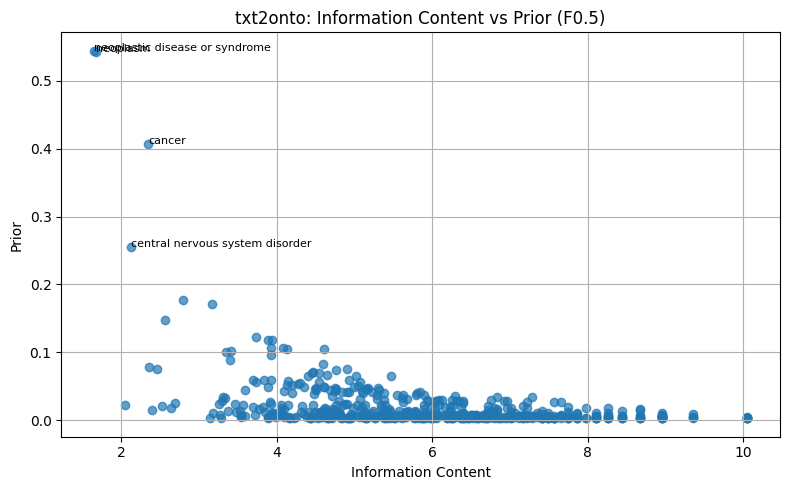

In [49]:
# Prior vs IC
plt.figure(figsize=(8, 5))
plt.scatter(txt2onto_label_f05['ic'], txt2onto_label_f05['prior'], alpha = 0.7)

# Fit a linear regression line
#m, b = np.polyfit(txt2onto_label_f05['ic'], txt2onto_label_f05['prior'], 1)
#plt.plot(txt2onto_label_f05['ic'], m * txt2onto_label_f05['ic'] + b, color='blue', label='Regression line')

# Add labels
for i, row in txt2onto_label_f05.iterrows():
    if row['prior'] > 0.2:
        plt.text(row['ic'], row['prior'], row['name'], fontsize=8, ha='left')

plt.xlabel('Information Content')
plt.ylabel('Prior')
plt.title('txt2onto: Information Content vs Prior (F0.5)')
plt.grid(True)
plt.tight_layout()
plt.show()

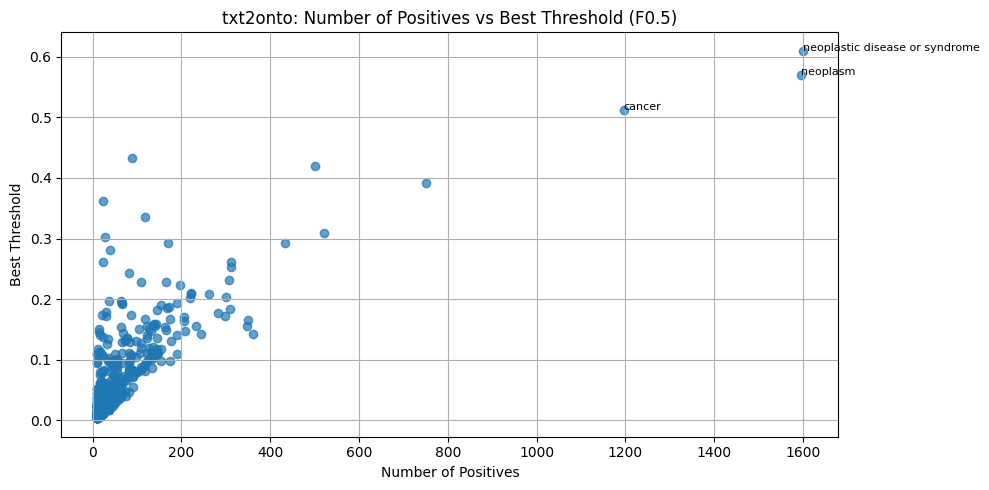

In [ ]:
# Number of Positives
plt.figure(figsize=(10, 5))
plt.scatter(txt2onto_label_f05['num_of_pos'], txt2onto_label_f05['best_threshold'], alpha = 0.7)

# Fit a linear regression line
#m, b = np.polyfit(txt2onto_label_f05['num_of_pos'], txt2onto_label_f05['best_threshold'], 1)
#plt.plot(txt2onto_label_f05['num_of_pos'], m * txt2onto_label_f05['num_of_pos'] + b, color='blue', label='Regression line')

# Add labels
for i, row in txt2onto_label_f05.iterrows():
    if row['best_threshold'] > 0.5:
        plt.text(row['num_of_pos'], row['best_threshold'], row['name'], fontsize=8, ha='left')

plt.xlabel('Number of Positives')
plt.ylabel('Best Threshold')
plt.title('txt2onto: Number of Positives vs Best Threshold (F0.5)')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis:  
1. Relationship between the number of positives and Best Threshold.  
    x: Number of Positives - the count of positive samples for each term.  
    y: Best threshold - the threshold that yields the best F0.5 socre.  

    a. Most terms have very low number of positives.  
    b. The majority of the best thresholds fall between 0.0 and 0.2 with low number of positives.  
    c. As the number of positives increases, best thresholds also increases.  

    Takeaway: it seems a positive relationship between number of positives and the best threshold.  

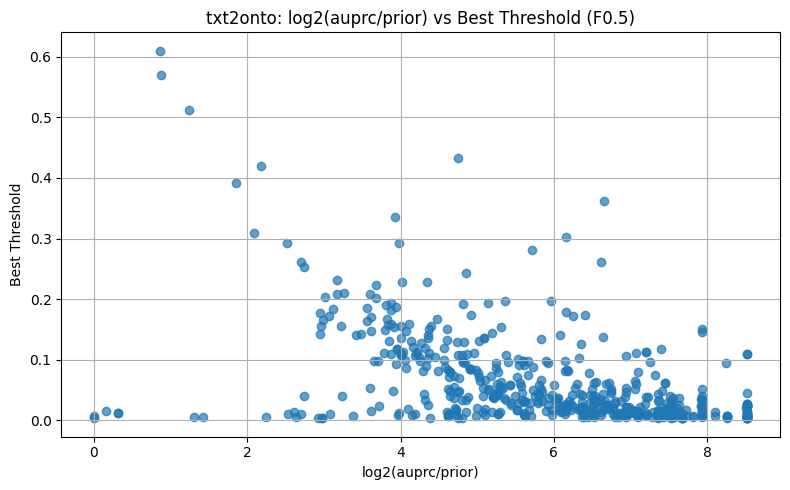

In [ ]:
# log2(auprc/prior)
plt.figure(figsize=(8, 5))
plt.scatter(txt2onto_label_f05['log2(auprc/prior)'], txt2onto_label_f05['best_threshold'], alpha = 0.7)

# Fit a linear regression line
#m, b = np.polyfit(txt2onto_label_f05['log2(auprc/prior)'], txt2onto_label_f05['best_threshold'], 1)
#plt.plot(txt2onto_label_f05['log2(auprc/prior)'], m * txt2onto_label_f05['log2(auprc/prior)'] + b, color='blue', label='Regression line')

plt.xlabel('log2(auprc/prior)')
plt.ylabel('Best Threshold')
plt.title('txt2onto: log2(auprc/prior) vs Best Threshold (F0.5)')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis:  
1. Relationship between log2(auprc/prior) and Best Threshold.  
    x: log2(auprc/prior) - a nomalized metric evaluating the model performance relative to a random classifier.  
    y: Best threshold - the threshold that yields the best F0.5 socre.  

    a. Most of the terms have a low best threshold (0.0 to 0.1).  
    b. For the models with poor performance (<3), the best threshold is either high or low. 
    c. Most of the model's performance are above 3.

    Takeaway: there is a negative relationship between the model performance (log2(auprc/prior)) and the Best Threshold.  

### ground truth label

In [33]:
label_f05 = label_f05.merge(id_map, left_on="task", right_on="id", how="left")
label_f05 = label_f05.drop(columns=["id"])
label_f05.head()

,task,best_threshold,prior,num_of_pos,num_of_pred_pos,name
0,MONDO:0020120,0.134234,0.011697,43,266,skeletal muscle disorder
1,MONDO:0700092,0.194167,0.022307,82,150,neurodevelopmental disorder
2,MONDO:0005101,0.053404,0.007619,28,182,ulcerative colitis
3,MONDO:0021143,0.082648,0.036997,136,1956,melanocytic neoplasm
4,MONDO:0005072,0.079651,0.034286,126,1024,neuroblastoma


In [34]:
label_f05.shape

(515, 6)

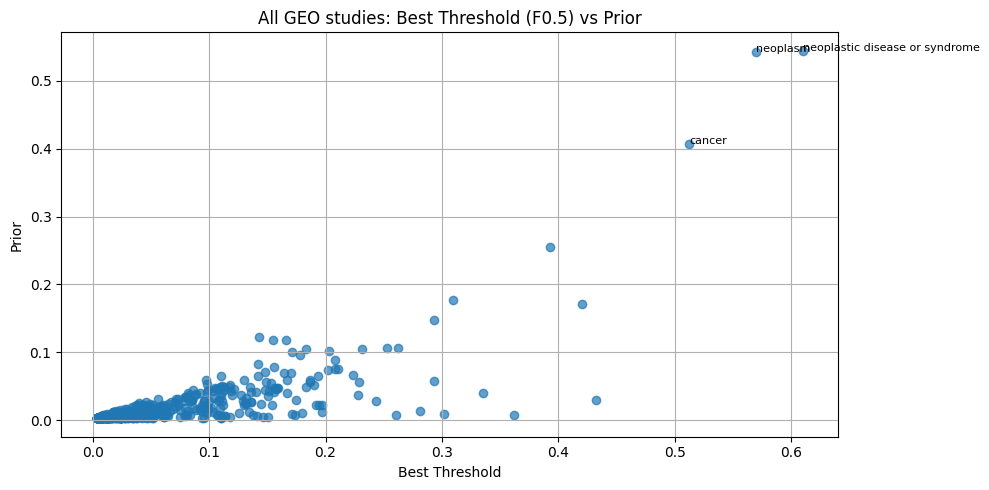

In [43]:
# Prior
plt.figure(figsize=(10, 5))
plt.scatter(label_f05['best_threshold'], label_f05['prior'], alpha=0.7)

# Fit a linear regression line
#m, b = np.polyfit(label_f05['best_threshold'], label_f05['prior'], 1)
#plt.plot(label_f05['best_threshold'], m * label_f05['best_threshold'] + b, color='blue', label='Regression line')

# Add labels for points above 1000
for i, row in label_f05.iterrows():
    if row['prior'] > 0.4:
        plt.text(row['best_threshold'], row['prior'], row['name'], fontsize=8, ha='left')

plt.xlabel('Best Threshold')
plt.ylabel('Prior')
plt.title('All GEO studies: Best Threshold (F0.5) vs Prior')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis:  
1. Relationship between the Best Threshold and prior.  
    x: Best threshold - the threshold that yields the best F0.5 socre.  
    y: Prior - The proportion of positive studies.   

    a. Most terms with low best thresholds (<0.1) have low prior (<0.1).  
    b. The best thresholds widely spread at priors under 0.1.  

    Takeaway: there is a positive relationship between the best threshold and the prior. Most of the terms have low best threshold and low prior.

In [36]:
# terms with highest prior
gt_prior_top_10_f05 = label_f05.sort_values(by="prior", ascending = False).head(10)
gt_prior_top_10_f05

,task,best_threshold,prior,num_of_pos,num_of_pred_pos,name
308,MONDO:0023370,0.610012,0.544070,2000,73868,neoplastic disease or syndrome
328,MONDO:0005070,0.569765,0.542437,1994,90965,neoplasm
503,MONDO:0004992,0.512290,0.406692,1495,42449,cancer
75,MONDO:0002602,0.392526,0.255441,939,11345,central nervous system disorder
204,MONDO:0005626,0.309243,0.177639,653,15294,epithelial neoplasm
29,MONDO:0004993,0.420037,0.170945,626,7083,carcinoma
156,MONDO:0005560,0.293006,0.147443,542,3373,brain disorder
153,MONDO:0002334,0.142671,0.122688,451,21467,hematopoietic and lymphoid system neoplasm
41,MONDO:0044881,0.165970,0.118912,437,13970,hematopoietic and lymphoid cell neoplasm
36,MONDO:0019044,0.155192,0.118095,434,16252,tumor of hematopoietic and lymphoid tissues


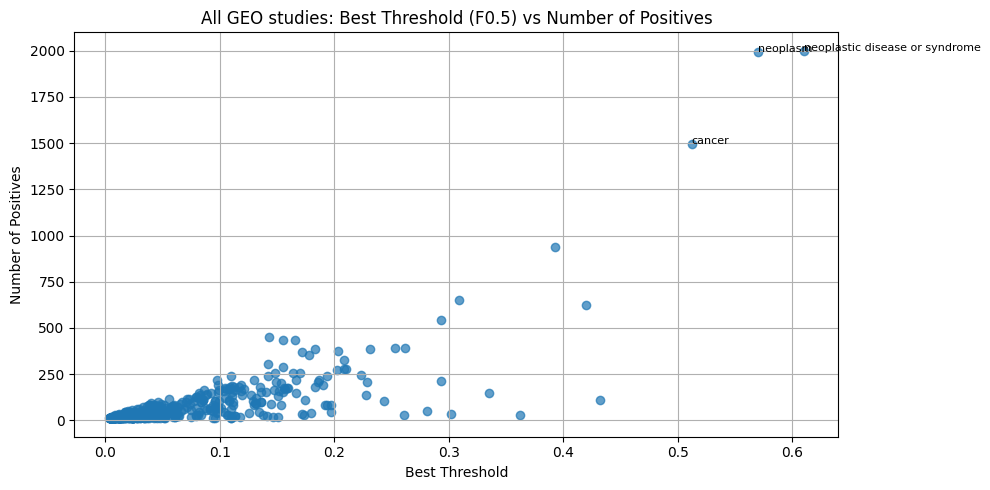

In [42]:
# Number of Positives
plt.figure(figsize=(10, 5))
plt.scatter(label_f05['best_threshold'], label_f05['num_of_pos'], alpha=0.7)

# Fit a linear regression line
#m, b = np.polyfit(label_f05['best_threshold'], label_f05['num_of_pos'], 1)
#plt.plot(label_f05['best_threshold'], m * label_f05['best_threshold'] + b, color='blue', label='Regression line')

# Add labels for points above 1000
for i, row in label_f05.iterrows():
    if row['num_of_pos'] > 1000:
        plt.text(row['best_threshold'], row['num_of_pos'], row['name'], fontsize=8, ha='left')

plt.xlabel('Best Threshold')
plt.ylabel('Number of Positives')
plt.title('All GEO studies: Best Threshold (F0.5) vs Number of Positives')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis:  
1. Relationship between the number of positives and Best Threshold.  
    x: Best threshold - the threshold that yields the best F0.5 socre.  
    y: Number of Positives - the count of positive studies for each term.  

    Takeaway: Similar to prior

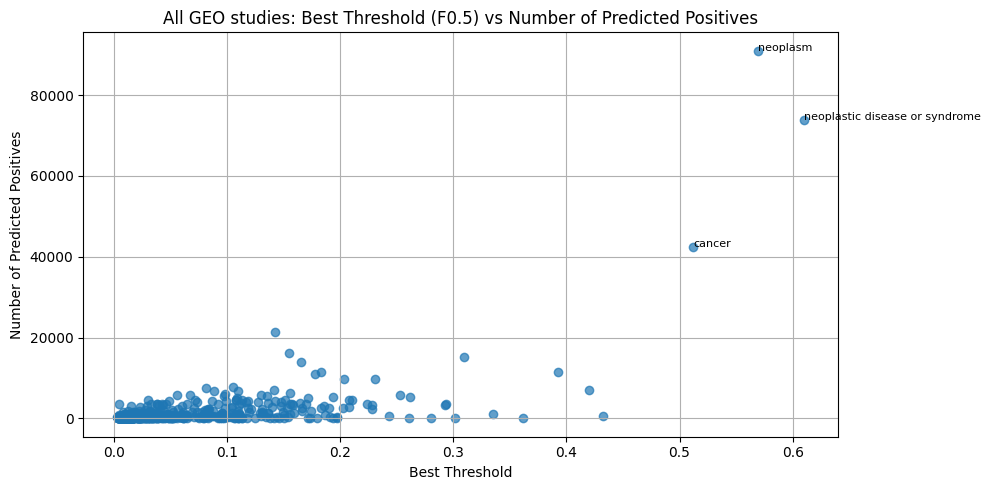

In [40]:
# Number of Predicted Positives
plt.figure(figsize=(10, 5))
plt.scatter(label_f05['best_threshold'], label_f05['num_of_pred_pos'], alpha = 0.7)

# Fit a linear regression line
#m, b = np.polyfit(label_f05['best_threshold'], label_f05['num_of_pred_pos'], 1)
#plt.plot(label_f05['best_threshold'], m * label_f05['best_threshold'] + b, color='blue', label='Regression line')

# Add labels for points above 30000
for i, row in label_f05.iterrows():
    if row['num_of_pred_pos'] > 30000:
        plt.text(row['best_threshold'], row['num_of_pred_pos'], row['name'], fontsize=8, ha='left')

plt.xlabel('Best Threshold')
plt.ylabel('Number of Predicted Positives')
plt.title('All GEO studies: Best Threshold (F0.5) vs Number of Predicted Positives')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis:  
1. Relationship between the number of positives and Best Threshold.  
    x: Best threshold - the threshold that yields the best F0.5 socre.  
    y: Number of Predicted Positives - the number of instances predicted as positive.  

    a. It seems like a slight positive relationship as the best threshold increases, the number of predicted positives also increases.  
    b. High best thresholds appear only at those with very large predicted positives.  
    c. The best threshold on those with very small number of predicted positives varies between 0 and 0.4.  